In [22]:
from datasets import load_dataset
import numpy as np

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.utils import save_image
from torchvision.transforms import Compose
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from pathlib import Path

from models.unet import Unet
from models.diffusion import linear_beta_schedule, p_losses


In [3]:
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

Found cached dataset fashion_mnist (C:/Users/zimen/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)
100%|██████████| 2/2 [00:00<00:00, 14.00it/s]


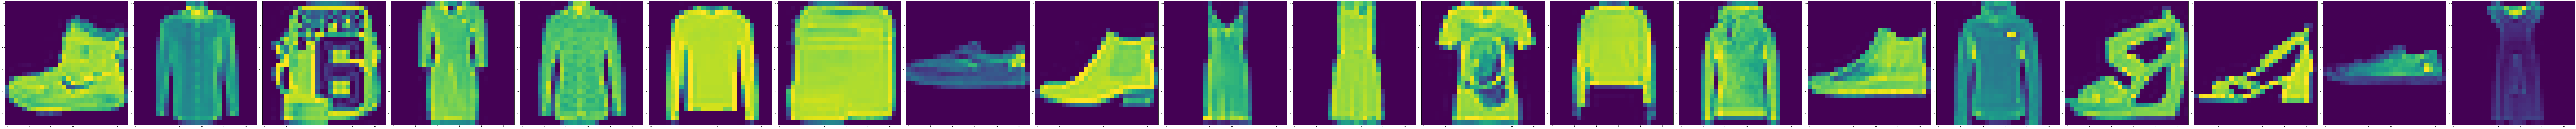

In [4]:
fig = plt.figure(figsize=(200,200))
num_rows = dataset['train'].num_rows // 3000
for i in range(20):
    fig.add_subplot(1, num_rows, i+1)
    plt.imshow(dataset['train'][i * 3000]['image'])

plt.tight_layout()

In [9]:
transform = Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1),
])

def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

In [10]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


In [11]:
# Train the model
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok=True)
save_and_sample_every = 1

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [23]:
timesteps=200

# define beta schedule (noise)
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculate for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculate for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [24]:
epochs = 20
for epoch in range(epochs):
    print("Epoch:", epoch)
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch['pixel_values'].shape[0]
        batch = batch['pixel_values'].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        loss = p_losses(model, batch, t, sqrt_alphas_cumprod=sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod, loss_type="huber")

        if step % 200 == 0:
            print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

        ''' save generated images
        if step != 0 and step % save_and_sample_every == 0:
            milestone = step // save_and_sample_every
            batches = num_to_groups(4, batch_size)
            all_images_list = torch.Tensor(list(map(lambda n: sample(model, image_size=image_size, batch_size=n, channels=channels), batches)))
            all_images = torch.cat([all_images_list], dim=0)
            all_images = (all_images + 1) * 0.5
            
            save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow=6)
        '''

Epoch: 0
Loss: 0.47002896666526794
Loss: 0.08897962421178818
Loss: 0.06553713977336884
Epoch: 1
Loss: 0.05445250868797302
Loss: 0.054393306374549866
Loss: 0.05078459903597832
Epoch: 2
Loss: 0.04634050279855728
Loss: 0.051166560500860214
Loss: 0.05554381012916565
Epoch: 3
Loss: 0.05988377332687378
Loss: 0.046626247465610504
Loss: 0.05146549269556999
Epoch: 4
Loss: 0.04050746187567711
Loss: 0.04534026235342026
Loss: 0.043822672218084335
Epoch: 5
Loss: 0.04506240040063858
Loss: 0.03959329426288605
Loss: 0.04474993795156479
Epoch: 6
Loss: 0.040458858013153076
Loss: 0.03863857313990593
Loss: 0.04076992720365524
Epoch: 7
Loss: 0.04316575080156326
Loss: 0.04315833002328873
Loss: 0.034661002457141876
Epoch: 8
Loss: 0.04552999138832092
Loss: 0.04207654297351837
Loss: 0.04077877476811409
Epoch: 9
Loss: 0.0418526791036129
Loss: 0.04137555509805679
Loss: 0.04540179669857025
Epoch: 10
Loss: 0.038165125995874405
Loss: 0.042803093791007996
Loss: 0.03689906746149063
Epoch: 11
Loss: 0.03839693590998649

In [57]:
import models.diffusion as diffusion

samples = diffusion.sample(model, timesteps, image_size, betas, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, posterior_variance, batch_size=64, channels=channels)


sampling loop time step: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


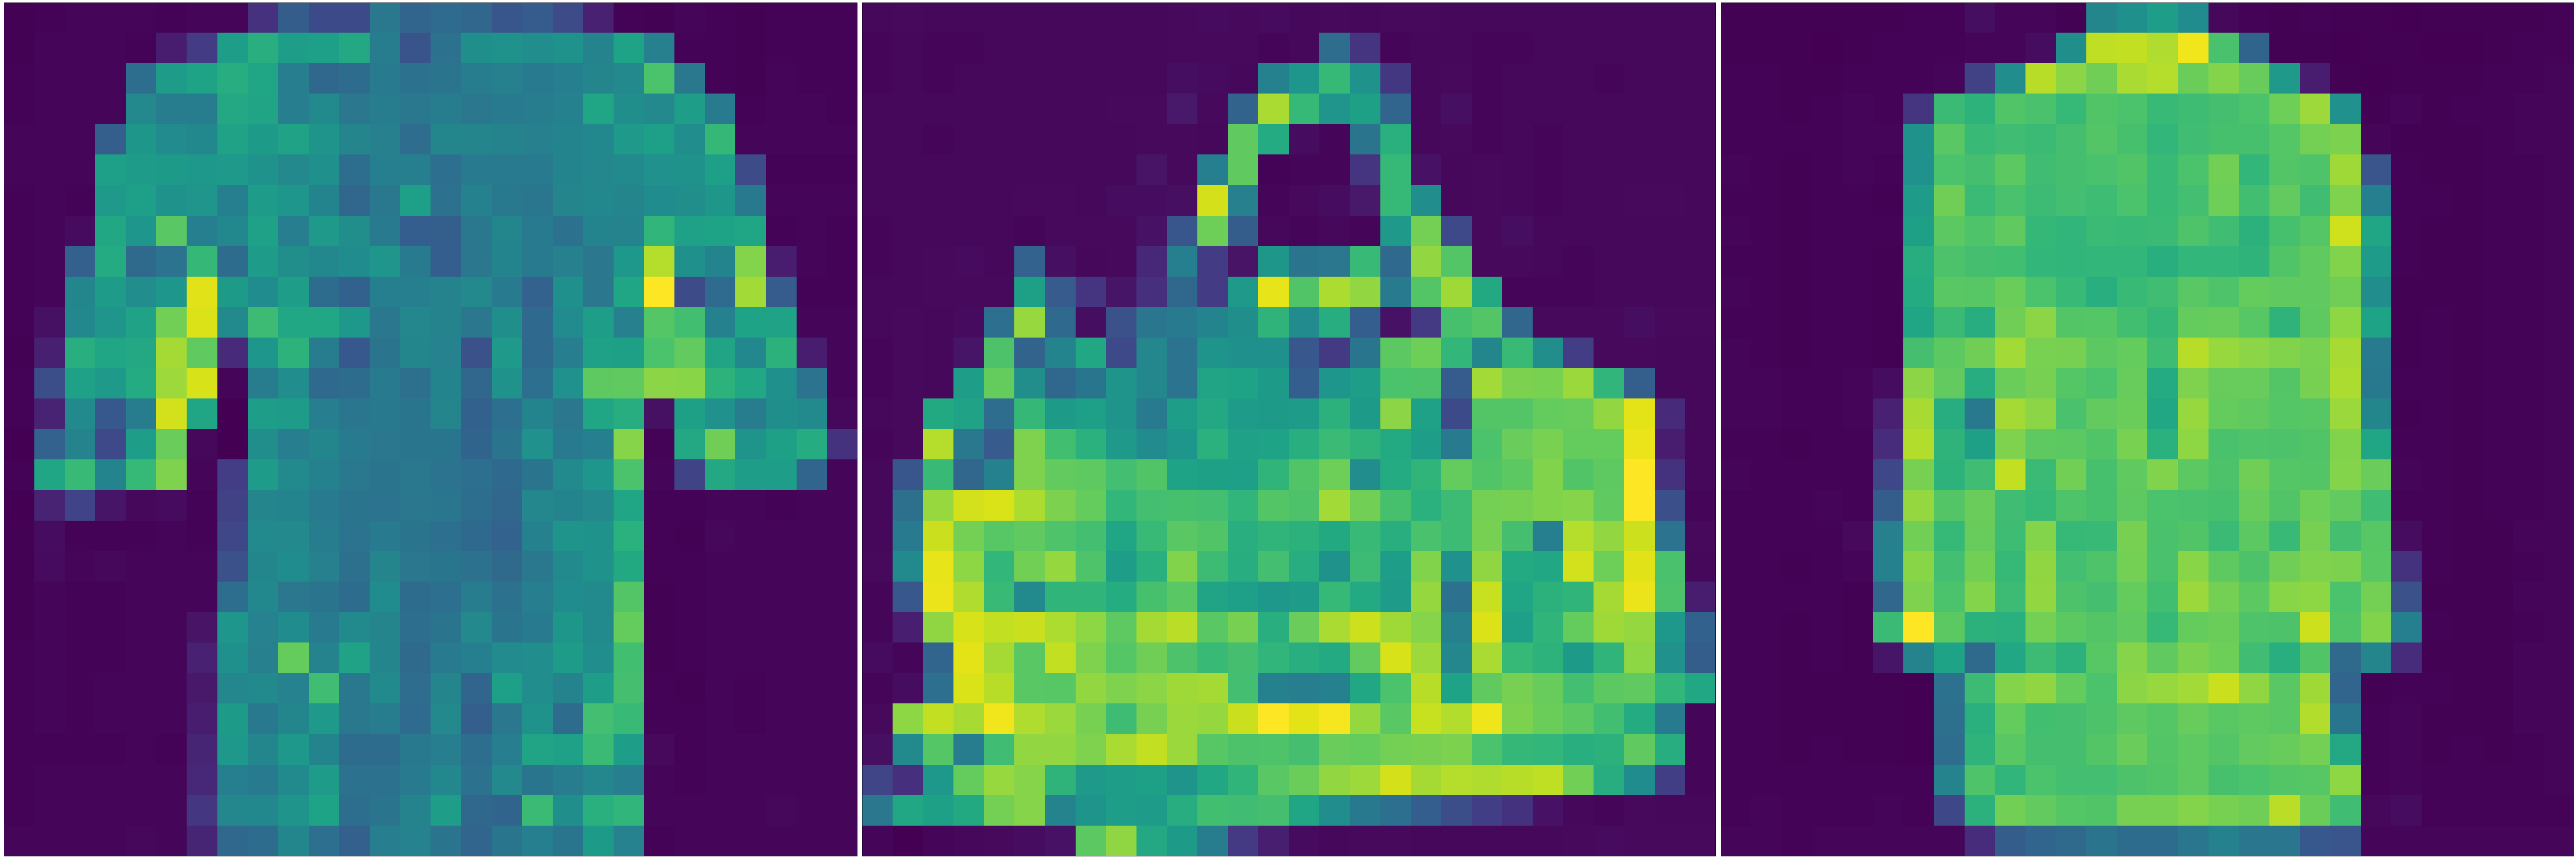

In [64]:
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(100,100), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [imgs] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original Image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    
    plt.tight_layout()

plot([samples[-1][t].reshape(image_size, image_size, channels) for t in [2, 26, 34]])

MovieWriter ffmpeg unavailable; using Pillow instead.


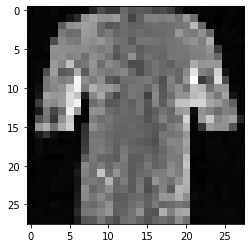

MovieWriter ffmpeg unavailable; using Pillow instead.


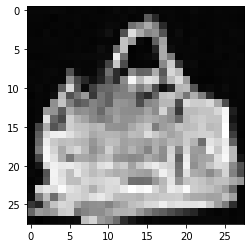

MovieWriter ffmpeg unavailable; using Pillow instead.


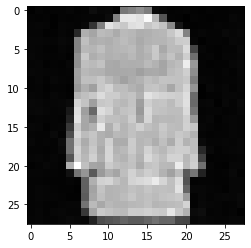

In [65]:
import matplotlib.animation as animation

for random_index in [2, 26, 34]:
    fig = plt.figure()
    ims = []
    for i in list(range(0, timesteps - 60, 4)) + list(range(timesteps - 60, timesteps, 2)):
        ims.append([plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)])

    animate = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=10000, blit=True)

    animate.save("results/diffusion" + str(random_index) + ".gif")
    plt.show()